# Predict How Late Airline Flights Will Be
#### A flight only counts as late if it is more than 30 minutes late

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sklearn
import time
import seaborn as sns

from IPython.display import display
pd.options.display.max_columns = None

from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

import warnings
warnings.filterwarnings('ignore')

In [27]:
# load in data
t1=time.time()
data = pd.read_csv('2008.csv.bz2')
t2=time.time()
print('Time to load: {}'.format(t2-t1))

Time to load: 61.630539655685425


In [3]:
#load data in chunks
t0=time.time()
df=pd.DataFrame()
for chunk in pd.read_csv('2008.csv.bz2', chunksize=500000, low_memory=False):
    df = pd.concat([df,chunk])
t1=time.time()
print('Time to load in chunks: {}'.format(t1-t0))

Time to load in chunks: 87.67223763465881


Time to load in chunks: 853.8577709197998 - when something was wrong....

In [7]:
# sample down to perform analysis
dfsam = data.sample(100000)
print(dfsam.describe(include='all'))

            Year          Month    DayofMonth      DayOfWeek       DepTime  \
count   100000.0  100000.000000  100000.00000  100000.000000  98041.000000   
unique       NaN            NaN           NaN            NaN           NaN   
top          NaN            NaN           NaN            NaN           NaN   
freq         NaN            NaN           NaN            NaN           NaN   
mean      2008.0       6.346010      15.70377       3.918690   1334.482380   
std          0.0       3.402479       8.79175       1.986771    477.979487   
min       2008.0       1.000000       1.00000       1.000000      1.000000   
25%       2008.0       3.000000       8.00000       2.000000    928.000000   
50%       2008.0       6.000000      16.00000       4.000000   1325.000000   
75%       2008.0       9.000000      23.00000       6.000000   1729.000000   
max       2008.0      12.000000      31.00000       7.000000   2400.000000   

           CRSDepTime       ArrTime    CRSArrTime UniqueCarrier

In [8]:
# Drop useless variables
dfsam.drop(['Year','TailNum', 'FlightNum', 'UniqueCarrier'], 1, inplace=True)

# Fill missing in CancellationCode with none
dfsam.CancellationCode.fillna('none', inplace=True)

# Fill missing cause of delay variables with 0
dfsam.fillna({'CarrierDelay':0, 'WeatherDelay':0, 'NASDelay':0, 'SecurityDelay':0, 'LateAircraftDelay':0}, inplace=True)

In [9]:
dfsam.dropna(inplace=True)
dfsam.shape

(97788, 25)

Now we have the same number of entries as the dependent variable. Check distribution of dependent variable.

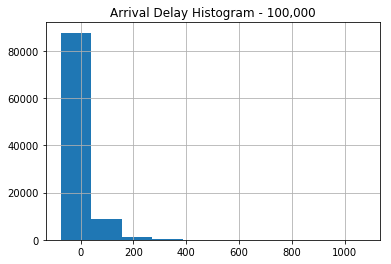

In [10]:
dfsam.ArrDelay.hist()
plt.title('Arrival Delay Histogram - 100,000')
plt.show()

In [11]:
# use power transformer from sklearn to handle negative values
pt = PowerTransformer()
y = dfsam.ArrDelay.values.reshape(-1,1)
y_transform = pt.fit_transform(y)

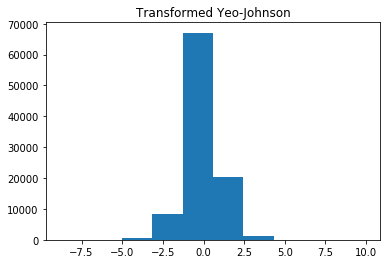

In [12]:
plt.hist(y_transform)
plt.title('Transformed Yeo-Johnson')
plt.show()

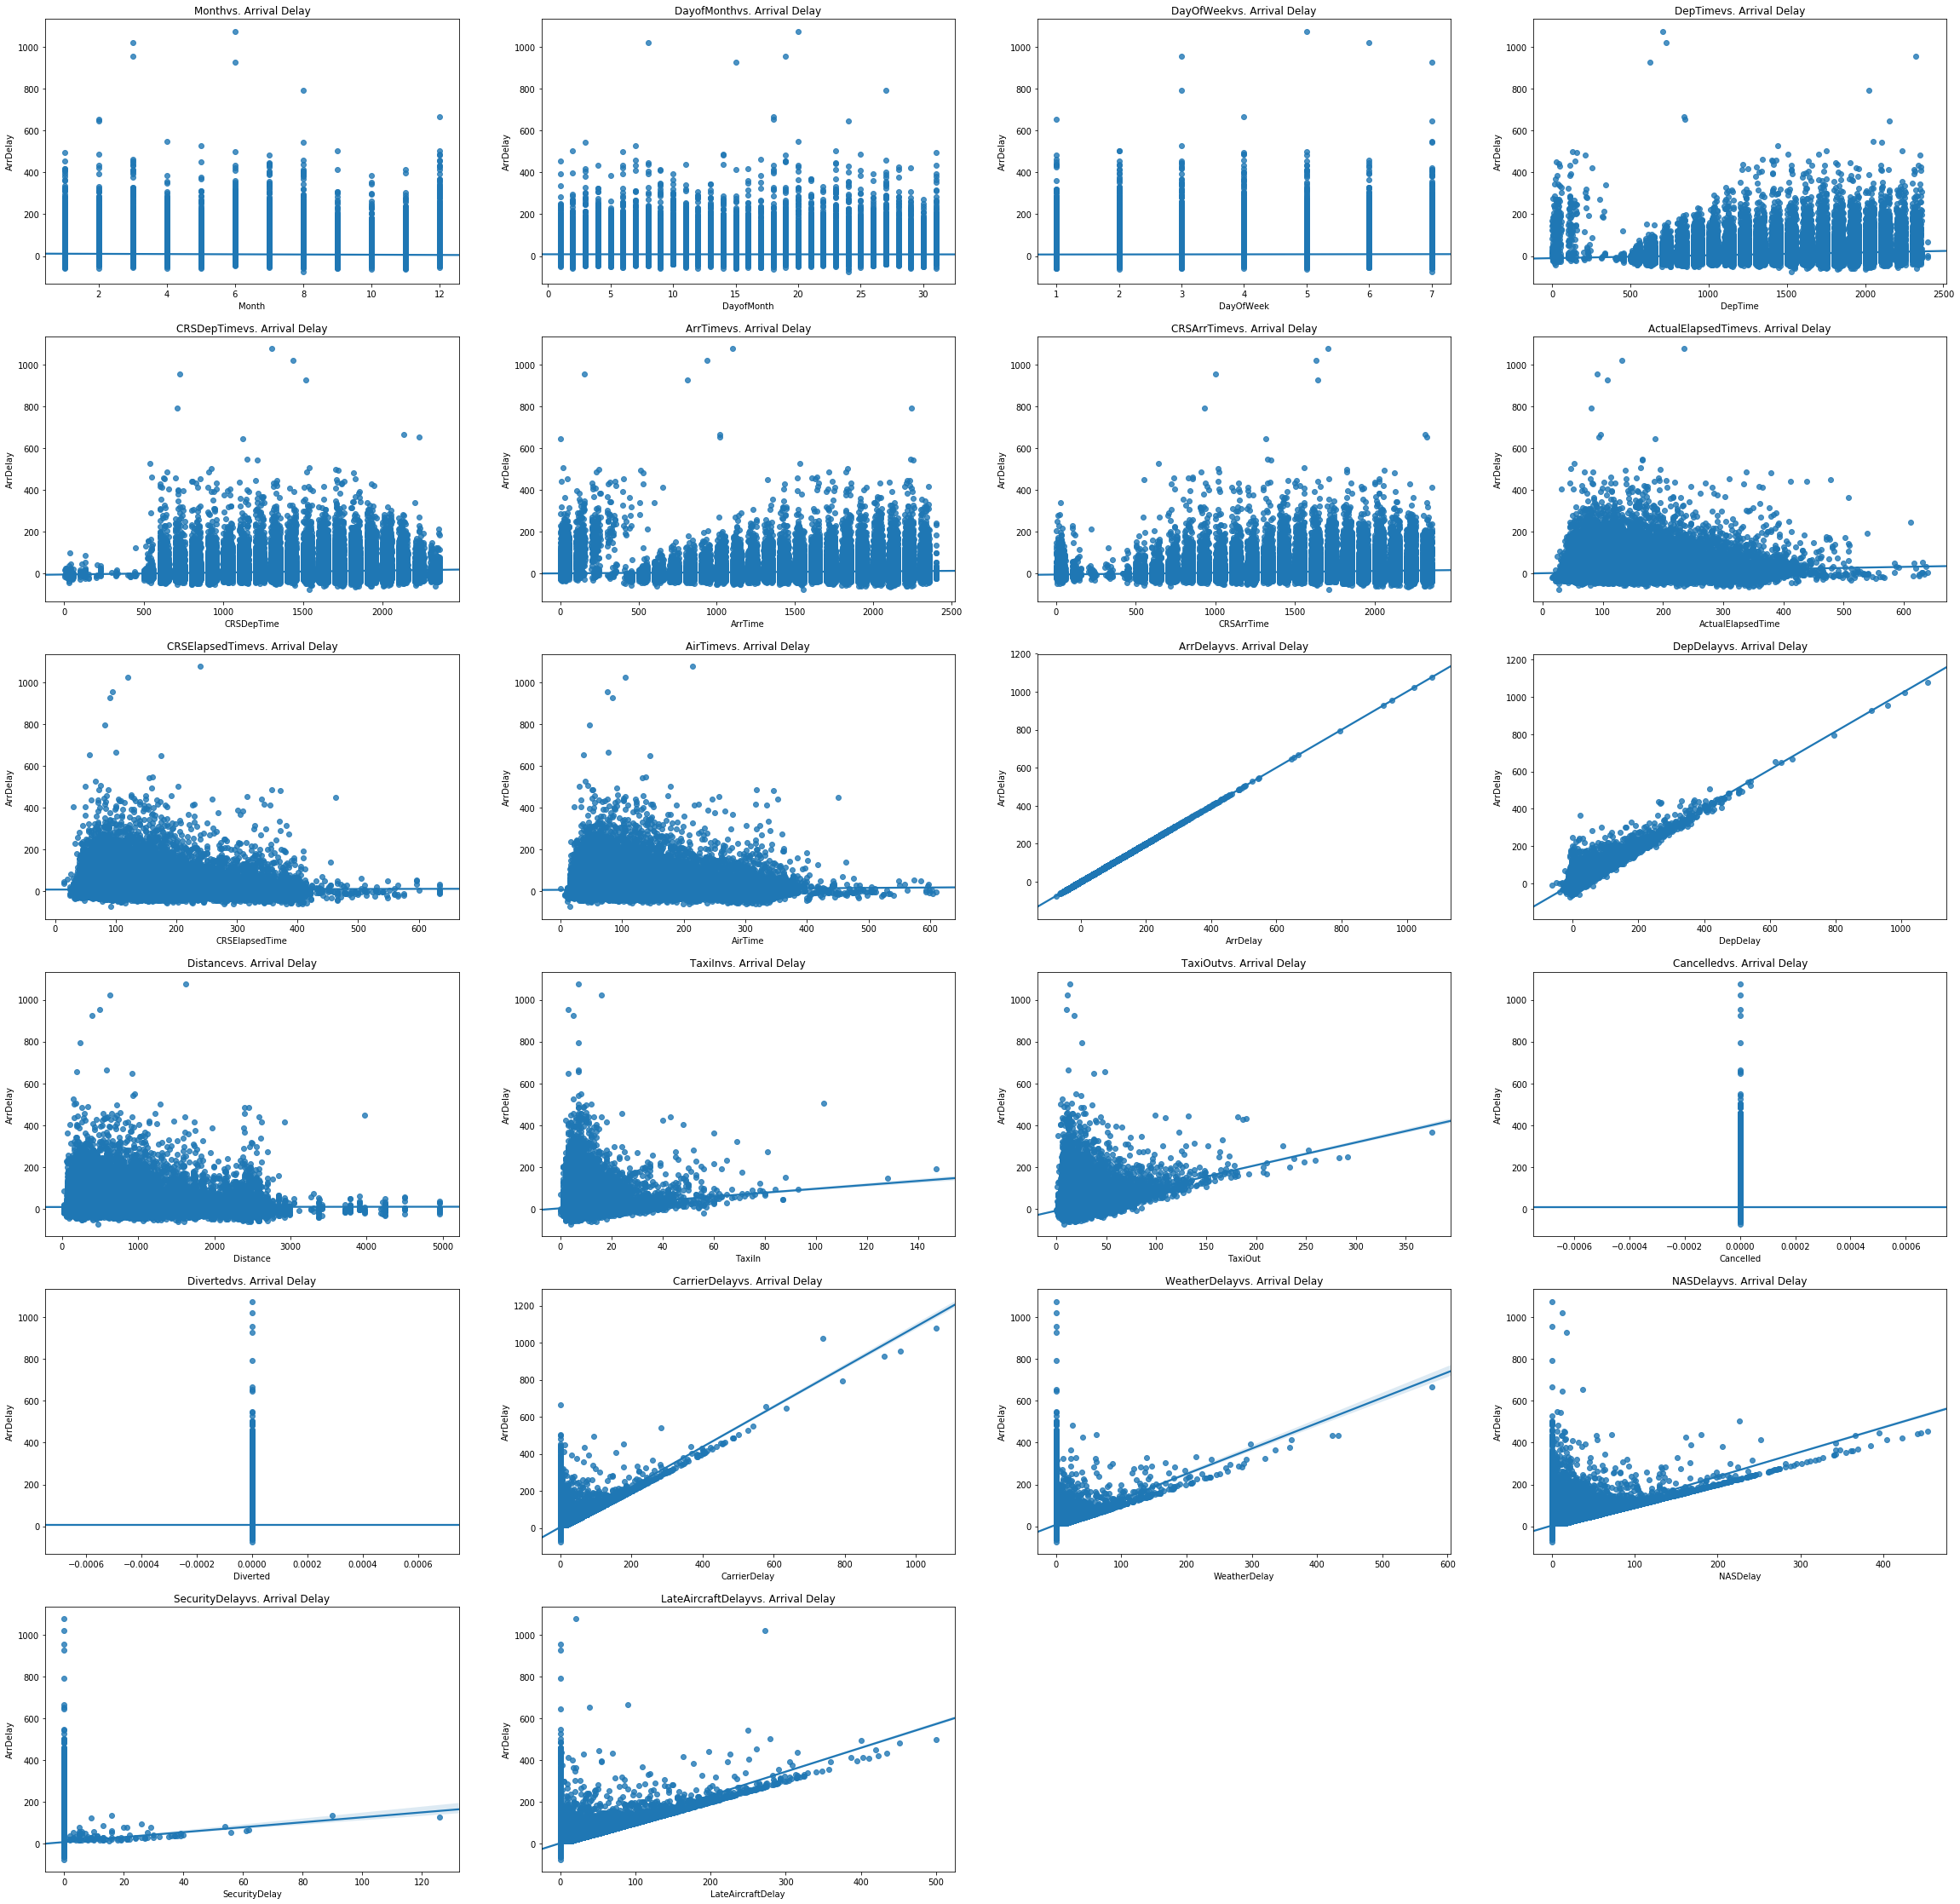

In [13]:
nums = dfsam.select_dtypes(exclude=['object'])
nmplt=0
fig = plt.figure(1, figsize=(40, 40))
for i in nums.columns:
    nmplt+=1
    ax=fig.add_subplot(6,4,nmplt)
    sns.regplot(x=i, y='ArrDelay', data=dfsam, ax=ax)
    plt.title(str(i) + 'vs. Arrival Delay')
plt.show()

We either have very linear realationships or zero linear relationships.  Let's first run a linear regression using only the linearly related variables.

In [14]:
feats = dfsam[['DepDelay', 'TaxiIn', 'TaxiOut', 
               'CarrierDelay', 'WeatherDelay', 'NASDelay', 
               'SecurityDelay', 'LateAircraftDelay']]
y = dfsam.ArrDelay

In [42]:
# create function for modeling
def model(mod, x, y, cv=5):

    # initialize and fit model
    clf=mod
    fitted = clf.fit(x,y)
    
    # predict
    clf.predict(x)
    
    # score
    print('Model score: {}'.format(clf.score(x,y)))
    
    # validate
    scores = cross_val_score(clf,x,y,cv=cv)
    print('Cross Validation:')
    print(scores)
    return fitted

In [43]:
xtrain, xtest, ytrain, ytest = train_test_split(nums.drop('ArrDelay',1), y_transform, test_size=.2)

In [44]:
linreg = model(LinearRegression(), xtrain, ytrain)

Model score: 0.949385585683504
Cross Validation:
[0.94607143 0.9507912  0.94906575 0.94955645 0.95033997]


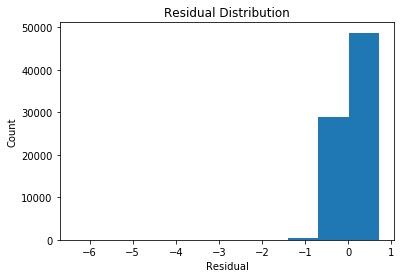

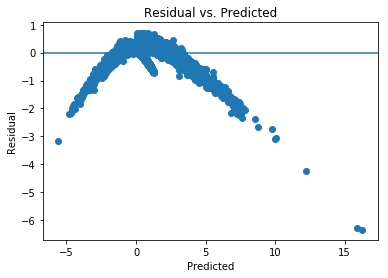

In [45]:
# check residuals
pred_y = linreg.predict(xtrain)
residual = ytrain - pred_y

plt.hist(residual)
plt.title('Residual Distribution')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

plt.scatter(pred_y, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [46]:
# test
linreg.score(xtest, ytest)

0.9483224804696534

In [47]:
# scaled data
scale = MinMaxScaler()
scale.fit(nums.drop('ArrDelay',1))
scaledX = scale.transform(nums.drop('ArrDelay',1))

# split data
xtrains, xtests, ytrains, ytests = train_test_split(scaledX, y_transform, test_size=.2)

In [48]:
linregscale = model(LinearRegression(), xtrains, ytrains)

Model score: 0.9489795839723002
Cross Validation:
[0.95005334 0.95173617 0.94846315 0.94864062 0.94383544]


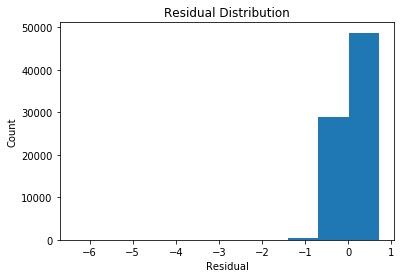

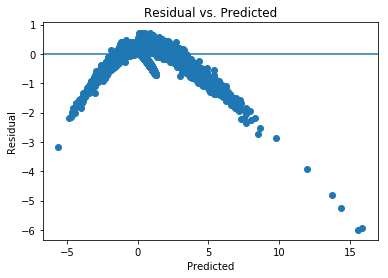

In [50]:
# check residuals
pred_ys = linregscale.predict(xtrains)
residuals = ytrains - pred_ys

plt.hist(residual)
plt.title('Residual Distribution')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

plt.scatter(pred_ys, residuals)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

Now we need to test on full dataset - to do that we will need to transform the 'ArrDelay variable and run against only the numeric variables.

In [28]:
# Drop useless variables
data.drop(['Year','TailNum', 'FlightNum', 'UniqueCarrier'], 1, inplace=True)

# Fill missing in CancellationCode with none
data.CancellationCode.fillna('none', inplace=True)

# Fill missing cause of delay variables with 0
data.fillna({'CarrierDelay':0, 'WeatherDelay':0, 'NASDelay':0, 'SecurityDelay':0, 'LateAircraftDelay':0}, inplace=True)

# drop the rest of the missing
data.dropna(inplace=True)

# drop object variables
data = data.select_dtypes(exclude=['object'])

# transform the full dataset dependent
yfull = data.ArrDelay.values.reshape(-1,1)
full_transform = pt.fit_transform(yfull)

# check shape
print(data.shape)

(6855029, 22)


In [29]:
Xfull = data.drop('ArrDelay', 1)
print(Xfull.shape)
target = full_transform.ravel()
print(target.shape)

(6855029, 21)
(6855029,)


In [51]:
linreg.score(Xfull, target)

0.9473004024876439

In [52]:
linreg.coef_

array([[-8.62956058e-04,  1.78318241e-05, -1.94370762e-04,
         1.24851630e-04, -1.08519368e-04,  3.51677800e-06,
         9.01960008e-07,  5.70266024e-02, -7.83842020e-02,
         2.04353717e-02,  7.25860161e-02,  8.80527802e-05,
         1.81982318e-02,  1.83929990e-02,  2.77555756e-17,
        -1.38777878e-17, -5.75053504e-02, -5.81247065e-02,
        -5.68676233e-02, -5.07053305e-02, -5.63008914e-02]])

In [53]:
Xfull.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime',
       'CRSArrTime', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime',
       'DepDelay', 'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'Diverted',
       'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
       'LateAircraftDelay'],
      dtype='object')

In [64]:
print(pd.DataFrame(list(zip(Xfull.columns,linreg.coef_.ravel())),columns=['Feature','Coefficient']))

              Feature   Coefficient
0               Month -8.629561e-04
1          DayofMonth  1.783182e-05
2           DayOfWeek -1.943708e-04
3             DepTime  1.248516e-04
4          CRSDepTime -1.085194e-04
5             ArrTime  3.516778e-06
6          CRSArrTime  9.019600e-07
7   ActualElapsedTime  5.702660e-02
8      CRSElapsedTime -7.838420e-02
9             AirTime  2.043537e-02
10           DepDelay  7.258602e-02
11           Distance  8.805278e-05
12             TaxiIn  1.819823e-02
13            TaxiOut  1.839300e-02
14          Cancelled  2.775558e-17
15           Diverted -1.387779e-17
16       CarrierDelay -5.750535e-02
17       WeatherDelay -5.812471e-02
18           NASDelay -5.686762e-02
19      SecurityDelay -5.070533e-02
20  LateAircraftDelay -5.630089e-02
